# Book Recommender System

**Task Description:**

-	Perform collaborative filtering using k-NN to identify user clusters using common book ratings and employ the top k-nearest neighbor average rating to predict outcomes.
-	Combine the rating data with the total rating count data to determine which books are popular while excluding less popular ones.
-	A Python Function that takes user id as input and show the top-10 recommended books for the user.
-	Another Python Function that takes user id and ISBN as input and show the probable rating of that book by that user.

# Load, View Data and Show Analysis on Rows and Columns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
'''
- Delimiter is set to semicolon (';') to handle data separated by semicolons
- Encoding is specified as 'latin-1' to handle character encoding issues
'''

books = pd.read_csv('/content/drive/MyDrive/BX_Books.csv', sep=';', encoding='latin-1')
book_ratings = pd.read_csv('/content/drive/MyDrive/BX-Book-Ratings.csv', sep=';', encoding='latin-1')
users = pd.read_csv('/content/drive/MyDrive/BX-Users.csv', sep=';', encoding='latin-1')

In [ ]:
display(books.columns, book_ratings.columns, users.columns)

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
      dtype='object')

Index(['User-ID', 'ISBN', 'Book-Rating'], dtype='object')

Index(['User-ID', 'Location', 'Age'], dtype='object')

In [ ]:
books.drop(['Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)

In [ ]:
cols_b = {
    'ISBN': 'isbn',
    'Book-Title': 'book_title',
    'Book-Author': 'book_author',
    'Year-Of-Publication': 'year_of_publication',
    'Publisher': 'publisher',
    'Image-URL-S': 'img_url_s'
}
books.rename(columns=cols_b, inplace=True)

In [ ]:
cols_br = {
    'User-ID': 'user_id',
    'ISBN': 'isbn',
    'Book-Rating': 'book_rating'
}
book_ratings.rename(columns=cols_br, inplace=True)
book_ratings.head()

,user_id,isbn,book_rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
print('Books:', books.shape)
print('Book Ratings:', book_ratings.shape)
print('Users:', users.shape)

Books: (271379, 6)
Book Ratings: (1149780, 3)
Users: (278858, 3)


In [ ]:
print('Info about the Books Dataset:')
print(books.info())
print('='*50)
print('Info about the Book Ratings Dataset:')
print(book_ratings.info())
print('='*50)
print('Info about the Users Dataset:')
print(users.info())

Info about the Books Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271379 entries, 0 to 271378
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   isbn                 271379 non-null  object
 1   book_title           271379 non-null  object
 2   book_author          271378 non-null  object
 3   year_of_publication  271379 non-null  int64 
 4   publisher            271377 non-null  object
 5   img_url_s            271379 non-null  object
dtypes: int64(1), object(5)
memory usage: 12.4+ MB
None
Info about the Book Ratings Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   user_id      1149780 non-null  int64 
 1   isbn         1149780 non-null  object
 2   book_rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage

- The 'books' dataset has missing values in 'book_author' (1) and 'publisher' (2).
- The 'book_ratings' dataset has no missing values.
- The 'users' dataset has a significant number of missing values in the 'Age' column (110762).

In [ ]:
print('Statistics about the Books Dataset:')
print(books.describe())
print('='*45)
print('Statistics about the Book Ratings Dataset:')
print(book_ratings.describe())
print('='*45)
print('Statistics about the Users Dataset:')
print(users.describe())

Statistics about the Books Dataset:
       year_of_publication
count        271379.000000
mean           1959.756050
std             258.011363
min               0.000000
25%            1989.000000
50%            1995.000000
75%            2000.000000
max            2050.000000
Statistics about the Book Ratings Dataset:
            user_id   book_rating
count  1.149780e+06  1.149780e+06
mean   1.403864e+05  2.866950e+00
std    8.056228e+04  3.854184e+00
min    2.000000e+00  0.000000e+00
25%    7.034500e+04  0.000000e+00
50%    1.410100e+05  0.000000e+00
75%    2.110280e+05  7.000000e+00
max    2.788540e+05  1.000000e+01
Statistics about the Users Dataset:
            User-ID            Age
count  278858.00000  168096.000000
mean   139429.50000      34.751434
std     80499.51502      14.428097
min         1.00000       0.000000
25%     69715.25000      24.000000
50%    139429.50000      32.000000
75%    209143.75000      44.000000
max    278858.00000     244.000000


- Data quality issues observed in both 'books' and 'users' datasets.
- Potential outliers and anomalies, such as unrealistic ages (range from 0 to 244) and unusual publication years (range from 0 to 2050).
- The mean rating is approximately 2.87 and the majority of ratings (50% and 75%) are 0. This suggests a significant number of implicit ratings (where users have not explicitly provided a rating).

In [ ]:
books.head()

,isbn,book_title,book_author,year_of_publication,publisher,img_url_s
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company,http://images.amazon.com/images/P/0393045218.0...


In [ ]:
book_ratings.head()

,user_id,isbn,book_rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


While 'books' dataset contains information about books (isbn, book-title, book-author etc.) and 'users' dataset contains user demographic information, these two datasets are not directly needed for collaborative filtering. However, we will use 'books' dataset to retrieve book details when presenting recommendations to users.

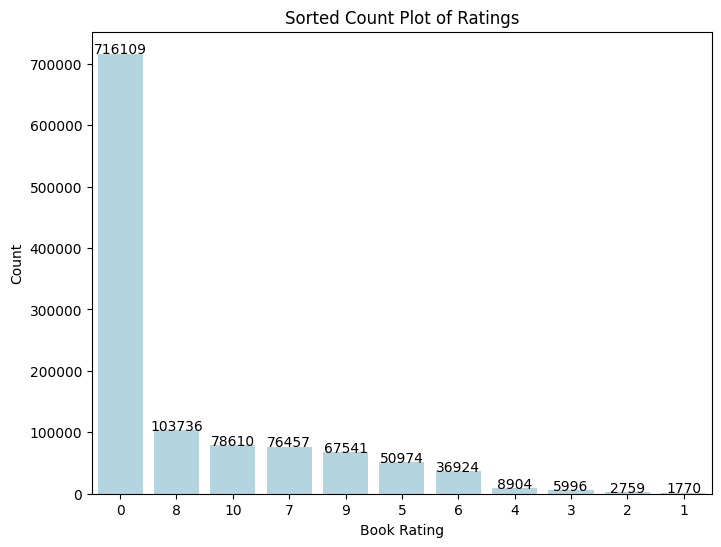

In [ ]:
# Histogram of ratings
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='book_rating', data=book_ratings, color='lightblue', order=book_ratings['book_rating'].value_counts().index)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')

plt.title('Sorted Count Plot of Ratings')
plt.xlabel('Book Rating')
plt.ylabel('Count')
plt.show()

In [ ]:
# Number of ratings per user
user_count = book_ratings['user_id'].value_counts()

# Top 5 users with most ratings
print('Top 5 Users with Most Ratings:')
user_count.head()

Top 5 Users with Most Ratings:


11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
Name: user_id, dtype: int64

In [ ]:
total_user = book_ratings['user_id'].nunique()
rated_user = book_ratings.loc[book_ratings['book_rating'] != 0, 'user_id'].nunique()
unrated_user = total_user - rated_user

print(f'Total number of unique users: {total_user}')
print(f'Number of users who have not given any ratings yet: {unrated_user}')

user_p = (unrated_user / total_user) * 100
print(f'Percentage of users who have not given any ratings yet: {user_p:.2f}%')

Total number of unique users: 105283
Number of users who have not given any ratings yet: 27478
Percentage of users who have not given any ratings yet: 26.10%


In [ ]:
book_count = book_ratings['isbn'].value_counts()

# Dictionary mapping ISBNs to book titles
map_books = books.set_index('isbn')['book_title'].to_dict()

# Map ISBN to book titles
top = book_count.head().reset_index()
top['book_title'] = top['index'].map(map_books)
top.columns = ['isbn', 'rating_count', 'book_title']

print('Top 5 Books with Most Ratings and Corresponding Book Names:')
top

Top 5 Books with Most Ratings and Corresponding Book Names:


,isbn,rating_count,book_title
0,0971880107,2502,Wild Animus
1,0316666343,1295,The Lovely Bones: A Novel
2,0385504209,883,The Da Vinci Code
3,0060928336,732,Divine Secrets of the Ya-Ya Sisterhood: A Novel
4,0312195516,723,The Red Tent (Bestselling Backlist)


In [ ]:
total_book = book_ratings['isbn'].nunique()
rated_book = book_ratings.loc[book_ratings['book_rating'] > 0, 'isbn'].nunique()
unrated_book = total_book - rated_book

print(f'Total number of unique books: {total_book}')
print(f'Number of books that have not been rated yet: {unrated_book}')

book_p = (unrated_book / total_book) * 100
print(f'Percentage of books that have not been rated yet: {book_p:.2f}%')

Total number of unique books: 340556
Number of books that have not been rated yet: 154583
Percentage of books that have not been rated yet: 45.39%


- A significant number of users have not provided ratings. This sparsity in user-item interactions can affect collaborative filtering accuracy.

- Some books have significantly more ratings than others, helping identify popular items. However, a considerable portion of the catalog lacks ratings posing a challenge for collaborative filtering in recommending unrated items.

# Collaborative Filtering using KNN

Collaborative Filtering is a recommendation technique used to create a recommendation algorithm based on the preferences of users or items.

There are two main types of collaborative filtering approaches. Here, we are using **User-User Collaborative Filtering** to solve the task. In this method, the preferences of a particular user are compared with the preferences of other users to find those with similar interests. Then, items liked by those similar users are recommended to the target user.

## Data Preparation

In [ ]:
# Combine rating data with total rating count data to determine which books are popular while excluding less popular ones
rating_count = book_ratings.groupby('isbn')['book_rating'].count()
average_rating = book_ratings.groupby('isbn')['book_rating'].mean()

popularity_threshold = 100
popular_books = rating_count[(rating_count >= popularity_threshold) & (average_rating > 0)]
filtered_books = book_ratings[book_ratings['isbn'].isin(popular_books.index)]

filtered_books.head()

,user_id,isbn,book_rating
2,276727,0446520802,0
8,276744,038550120X,7
10,276746,0425115801,0
11,276746,0449006522,0
12,276746,0553561618,0


In [ ]:
filtered_books.shape

(138461, 3)

We can not take every user's rating as the user is a novice reader with only an experience of reading a couple of books, his/her ratings might not be much relevant for finding similarity among users.

This approach reduce the dimensionality of the dataset and avoid running into *''memory error''*.

In [ ]:
threshold1 = 30

# Filter out users with less than the threshold interactions
user_counts = filtered_books['user_id'].value_counts()
valid_users = user_counts[user_counts >= threshold1].index
filtered_books = filtered_books[filtered_books['user_id'].isin(valid_users)]

In [ ]:
filtered_books.shape

(53542, 3)

# KNNBasic

The KNNBasic algorithm is a basic collaborative filtering algorithm in the Surprise library that predicts ratings for a user based on the ratings of their k-nearest neighbors (k-NN).

In [ ]:
!pip install scikit-surprise

In [ ]:
from surprise.model_selection import train_test_split
from surprise import Reader, Dataset, KNNBasic
from surprise.model_selection import GridSearchCV
from IPython.display import display, HTML

In [ ]:
reader = Reader(rating_scale=(0, 10))
data = Dataset.load_from_df(filtered_books[['user_id', 'isbn', 'book_rating']], reader)
trainset = data.build_full_trainset()

In [ ]:
param_grid = {
    'k': [50, 100, 150],
    'min_k': [5],
    'sim_options': {
        'name': ['pearson_baseline'],
        'user_based': [True]
    }
}

knn_model = KNNBasic()
grid_search = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=5)
grid_search.fit(data)

print('='*50)
cv_results = grid_search.cv_results
print('Cross-validation scores:')
for i in range(len(cv_results['params'])):
    params = cv_results['params'][i]
    mean_rmse = cv_results['mean_test_rmse'][i]
    print(f'Parameters: {params}, Mean RMSE: {mean_rmse}')

best_params = grid_search.best_params['rmse']
print(f'\nBest Hyperparameters: {best_params}')

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

In [ ]:
sim_options = {
    'name': 'pearson_baseline',
    'user_based': True
}

model = KNNBasic(sim_options=sim_options, k=100, min_k=5)
model.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


## Python Functions

**A Python Function that takes user id as input and shows the top-10 recommended books for the user.**

In [ ]:
def get_top_n_recommendations(user_id, n=10):
    all_books = filtered_books['isbn'].unique()
    unrated_books = list(set(all_books) - set(filtered_books[filtered_books['user_id'] == user_id]['isbn']))
    predictions = [model.predict(user_id, book) for book in unrated_books]
    sorted_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)
    top_n_recommendations = sorted_predictions[:n]
    return top_n_recommendations

In [ ]:
def display_top_recommendations(user_id):
    top_recommendations = get_top_n_recommendations(user_id)

    if not top_recommendations:
        print(f'No recommendations found for User {user_id}.')
        return

    html_code = f'<h2>Top 10 Recommendations for User {user_id}</h2>'

    for recommendation in top_recommendations:
        book_info = books[books['isbn'] == recommendation.iid]

        if not book_info.empty:
            book_info = book_info.iloc[0]
            html_code += f'<div style="display: flex; align-items: center; margin-bottom: 20px;">' \
                         f'<img src="{book_info["img_url_s"]}" alt="Book Cover" style="width:150px;height:200px;">' \
                         f'<div style="margin-left: 20px;">' \
                         f'<p><strong>ISBN:</strong> {recommendation.iid}</p>' \
                         f'<p><strong>Book Title:</strong> {book_info["book_title"]}</p>' \
                         f'<p><strong>Author:</strong> {book_info["book_author"]}</p>' \
                         f'<p><strong>Publisher:</strong> {book_info["publisher"]}</p>' \
                         f'<p><strong>Predicted Rating:</strong> {recommendation.est}</p>' \
                         f'</div>' \
                         f'</div>'
        else:
            print(f'Book information not found for ISBN: {recommendation.iid}')

    display(HTML(html_code))

In [ ]:
user_id_input = input('Enter the user ID: ')

try:
    user_id = int(user_id_input)

    if user_id in filtered_books['user_id'].unique():
        display_top_recommendations(user_id)
    else:
        print(f'User ID {user_id} not found in the filtered books.')
except ValueError:
    print('Invalid user ID. Please enter a valid numeric user ID.')

Enter the user ID: 35859


**Another Python Function that takes user id and ISBN as input and shows the probable rating of that book by that user.**

In [ ]:
def predict_rating(user_id, isbn):
    try:
        prediction = model.predict(user_id, isbn)
        return prediction.est
    except:
        return None

In [ ]:
user_id_input = int(input('Enter the user ID: '))
isbn_input = input('Enter the target ISBN: ')

if user_id not in filtered_books['user_id'].unique():
    print(f'User ID {user_id} not found in the training data.')
elif isbn_input not in filtered_books['isbn'].unique():
    print(f'Book with ISBN {isbn_input} not found in the training data.')
else:
    predicted_rating = predict_rating(user_id, isbn_input)
    print(f'Predicted rating for user {user_id} on book with ISBN {isbn_input}: {predicted_rating}')

Enter the user ID: 276727
Enter the target ISBN: 0446520802
Predicted rating for user 35859 on book with ISBN 0446520802: 3.013127657161313


In [ ]:
print(sorted(filtered_books['user_id'].unique())[:10])

[243, 254, 882, 2766, 3363, 4017, 5903, 6242, 6251, 6543]


In [ ]:
# Extracting actual and predicted ratings for a specific user to evaluate the model performance
def get_actual_predicted_ratings(user_id):
    user_ratings = filtered_books[(filtered_books['user_id'] == user_id) & (filtered_books['book_rating'] > 0)]
    predictions = [model.predict(user_id, isbn) for isbn in user_ratings['isbn']]

    ratings_df = pd.DataFrame({
        'ISBN': user_ratings['isbn'],
        'Actual Rating': user_ratings['book_rating'],
        'Predicted Rating': [prediction.est for prediction in predictions]
    })

    return ratings_df

user_id_to_show = 243
ratings_df = get_actual_predicted_ratings(user_id_to_show)
print(f'Actual and Predicted Ratings for User {user_id_to_show}:')
ratings_df

Actual and Predicted Ratings for User 243:


,ISBN,Actual Rating,Predicted Rating
9955,0060915544,10,8.709353
9956,0060977493,7,6.075415
9962,0316601950,9,6.923185
9966,0316776963,9,7.728425
9967,0316899984,7,5.915393
9989,0385720106,7,4.564289
9994,0425163407,9,7.666640
10001,044023722X,7,5.076594
10005,0446364800,9,8.325215
10012,0449006522,6,5.437880
